# Tilt axis identification

This notebook will show an example of how to identify the tilt axis of a sample holder, by means of a tilt series.

For this, you will need a tilt series of a sample, meaning the same sample scanned (and subsequently orientation mapped) at multiple different tilt angles.

For this tutorial, Orix's example dataset will be used, artificially tilted and with some added noise.
The noise is not meant to emulate the kind of orientation discrepancies expected from a real tilt series, but rather as a way to show a certain level of robustness.

In [1]:
# Import the necessary packages
%matplotlib inline
from matplotlib import pyplot as plt
from orix.vector import Vector3d
from scipy.optimize import minimize
import numpy as np
from orix.quaternion import Rotation
from itertools import combinations

import tiltlib

## Fabricating data

In this section, a tilt series is fabricated from one of Orix's example datasets.

If you have your own tilt series, you can skip this cell, and replace the `xmaps` list with a list of your own scans as `CrystalMap`-objects

In [2]:
# Make some fake tilt series data
from orix.data import sdss_austenite

# This is the raw data we will use
raw_xmap = sdss_austenite(allow_download=True)

# Arbitrarily choose the tilt axis direction. Should lie in or close to the xy-plane
axis_direction = Vector3d.xvector().rotate(Vector3d.zvector(), np.deg2rad(30))

# Choose a couple tilt angles
tilt_angles = [0, -10, 5, 15] # degrees

# Make a couple xmaps at the different tilt angles
xmaps = [raw_xmap.deepcopy() for _ in tilt_angles]
for xmap, tilt_angle in zip(xmaps, tilt_angles):

    # Manually modify the rotations with a rotation
    xmap._rotations[...] *= ~Rotation.from_axes_angles(axis_direction, tilt_angle, degrees=True)

    # Add some noise to every scan, at different intervals
    s = slice(None, None, np.random.randint(4, 10))
    xmap._rotations[s] *= Rotation.random(xmap._rotations.shape)[s]

xmaps

[Phase    Orientations       Name  Space group  Point group  Proper point group     Color
     0  11700 (100.0%)  austenite         None         m-3m                 432  tab:blue
 Properties: AvDotProductMap, CI, IQ, ISM, KAM, OSM, RefinedDotProducts, TopDotProductList, TopMatchIndices
 Scan unit: um,
 Phase    Orientations       Name  Space group  Point group  Proper point group     Color
     0  11700 (100.0%)  austenite         None         m-3m                 432  tab:blue
 Properties: AvDotProductMap, CI, IQ, ISM, KAM, OSM, RefinedDotProducts, TopDotProductList, TopMatchIndices
 Scan unit: um,
 Phase    Orientations       Name  Space group  Point group  Proper point group     Color
     0  11700 (100.0%)  austenite         None         m-3m                 432  tab:blue
 Properties: AvDotProductMap, CI, IQ, ISM, KAM, OSM, RefinedDotProducts, TopDotProductList, TopMatchIndices
 Scan unit: um,
 Phase    Orientations       Name  Space group  Point group  Proper point group     Colo

## Fitness function

To find which axis angle fits best, we need to be able to determine whether an axis position works well or not.
Here, we assume the samples are tilted along a given axis. We then compare each possible combination of scans, all rotated to 0 degrees tilt angle.
E.g. if one scan is tilted 5 degrees, one 10, and one 15, we virtually tilt all of them to 0 degrees, and we compare them all, pixel by pixel.
With all of these misorientation angles, we calculate the mean misorientation angle of the bottom third angles, to account for noise.

This fitness function is quite robust, as it compares all pixels throughout the entire scan, for all possible combinations of scans.
However, this makes it rather slow. One function evaluation takes around 2-3 seconds on a 4GHz AMD Ryzen 3900X processor.
Other fitness functions may provide faster computations.

In [9]:
def fitness(axis_angle: float):
    # Note the single input angle, as we assume the axis lies in the xy-plane, perpendicular to the optical axis.

    axis_direction = Vector3d.xvector().rotate(Vector3d.zvector(), np.deg2rad(axis_angle))

    samples: list[tiltlib.Sample] = []
    for xmap, angle in zip(xmaps, tilt_angles):
        s = tiltlib.Sample(xmap, [tiltlib.Axis(axis_direction, -30, 30, angle=angle, degrees=True)])
        s.rotate_to(0)
        samples.append(s)

    misorientation_angles = []
    
    for sample_a, sample_b in combinations(samples, 2):
        misorientation_angles.append(sample_a.orientations.angle_with(sample_b.orientations, degrees=True))
    misorientation_angles = np.array(misorientation_angles).flatten()
    
    # Choose the bottom third misorientation angles, as most of the large angles are probably due to noise / misindexation
    k = misorientation_angles.size // 3
    return np.mean(np.partition(misorientation_angles, k, axis=None)[:k])


## Performing the optimization
At this point, using e.g. `scipy.optimize.minimize` should yield the tilt axis position.
Additionally, we make a plot of the fitness score along a full rotation of axis positions, to show that the minima is indeed global.

In [10]:
res = minimize(
    fitness,
    0,
    bounds=((-180, 180),),
)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.00011030830627850421
        x: [ 3.000e+01]
      nit: 4
      jac: [ 3.522e-02]
     nfev: 54
     njev: 27
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [07:58<00:00,  2.66s/it]


Text(0, 0.5, 'Score')

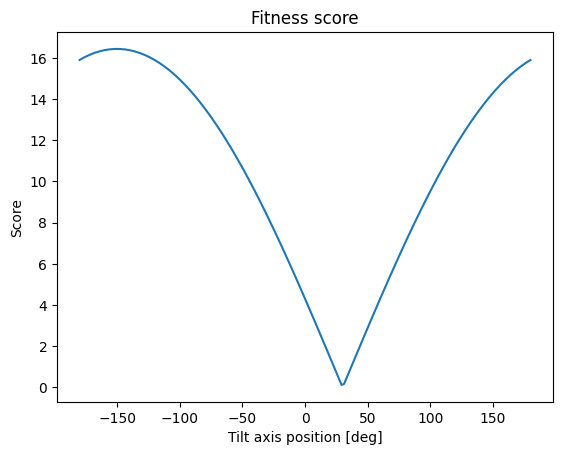

In [11]:
# We use tqdm to get a nice progress bar, as this is quite slow
from tqdm import tqdm

plt.figure()
plt.title("Fitness score")

angles = np.linspace(-180, 180, 180)
fitness_scores = [fitness(ang) for ang in tqdm(angles)]

plt.plot(angles, fitness_scores)
plt.xlabel("Tilt axis position [deg]")
plt.ylabel("Score")

From both the optimization and from manually inspecting the graph, we see the angle of the tilt axis with the x-axis is 30 degrees, as we set it to initially.